# Mapping $\mathbb R^2 \rightarrow \mathbb R$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl, matplotlib.pyplot as plt
import numpy as np
from neurodyn import *

In [3]:
rnn = LowRankCyclingRNN.new_valentin(p=2, N=20_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True, delta=6, shift=1)
res = rnn.simulate(rnn.F[:, 0], (0, 60), dt_max=0.4, progress=True, cache=True)

[LowRankCyclingRNN{N=20000, p=2, delta=6, shift=1, phi=sigmoid, I_ext=zero}] loading cached simulation 4cb4a2a356...


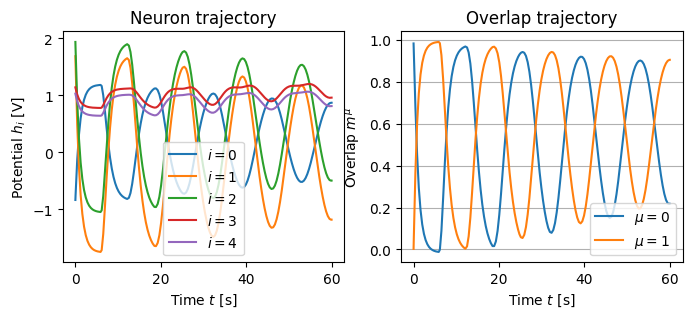

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
plot_neuron_trajectory(res, figax=(fig, axes[0]));
plot_overlap_trajectory(rnn, res, figax=(fig, axes[1]));

## 2D embedding

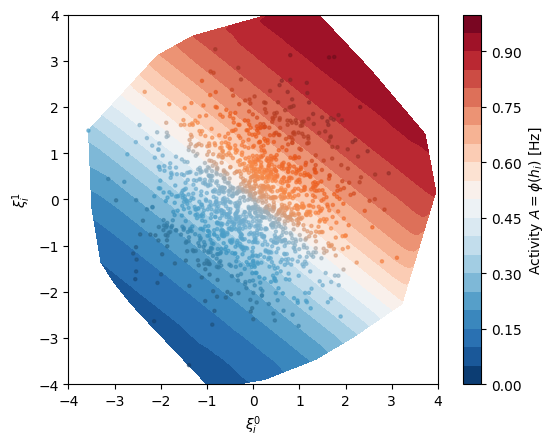

In [16]:
activity = rnn.phi(res.h[:, 3])
fig, ax = plt.subplots()
plot_2D_embedding_contour(rnn, activity, figax=(fig, ax))
plot_2D_embedding_scatter(rnn, activity, figax=(fig, ax))
ax.set_xlim((-4, 4))
ax.set_ylim((-4, 4))
plt.show()

## 1D embedding

### Cantor-type (bijection)

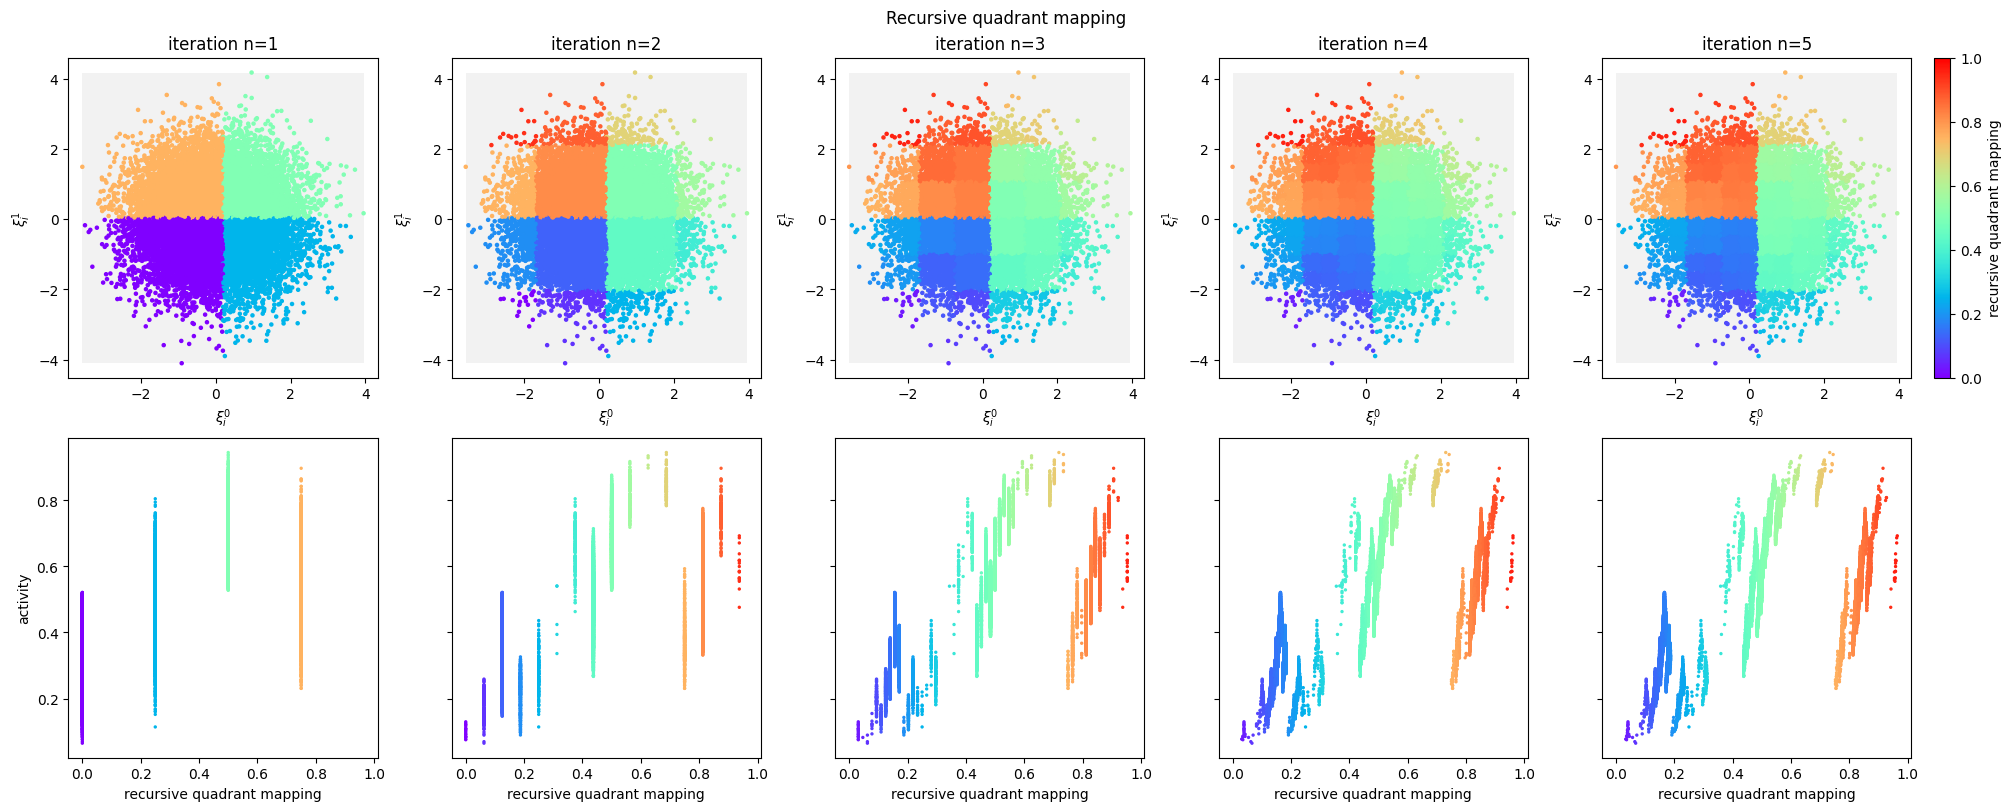

In [21]:
ns = [1, 2, 3, 4, 5]
fig, axes = plt.subplots(ncols=len(ns), nrows=2, figsize=(4*len(ns), 2*4), constrained_layout=True, sharex='row')
fig.suptitle('Recursive quadrant mapping')

for i, n in enumerate(ns):
	mapping = recursive_quadrant_mapping(rnn.F, n)
	bbox = Box(rnn.F[:, 0].min(), rnn.F[:, 0].max(), rnn.F[:, 1].min(), rnn.F[:, 1].max())
	axes[0, i].add_patch(plt.Rectangle((bbox.xmin, bbox.ymin), bbox.xmax-bbox.xmin, bbox.ymax-bbox.ymin, fc='k', alpha=0.05))
	sc_mapping = axes[0, i].scatter(rnn.F[:, 0], rnn.F[:, 1], c=mapping, cmap='rainbow', vmin=0, vmax=1, s=5)
	axes[0, i].set_title(f'iteration {n=}')
	axes[0, i].set_xlabel('$\\xi_i^0$')
	axes[0, i].set_ylabel('$\\xi_i^1$')

	axes[1, i].scatter(mapping, activity, c=mapping, cmap='rainbow', vmin=0, vmax=1, s=2)
	axes[1, i].set_xlabel('recursive quadrant mapping')
	axes[1, i].set_ylabel('activity')
	axes[1, i].label_outer()

fig.colorbar(sc_mapping, label='recursive quadrant mapping')
plt.show()

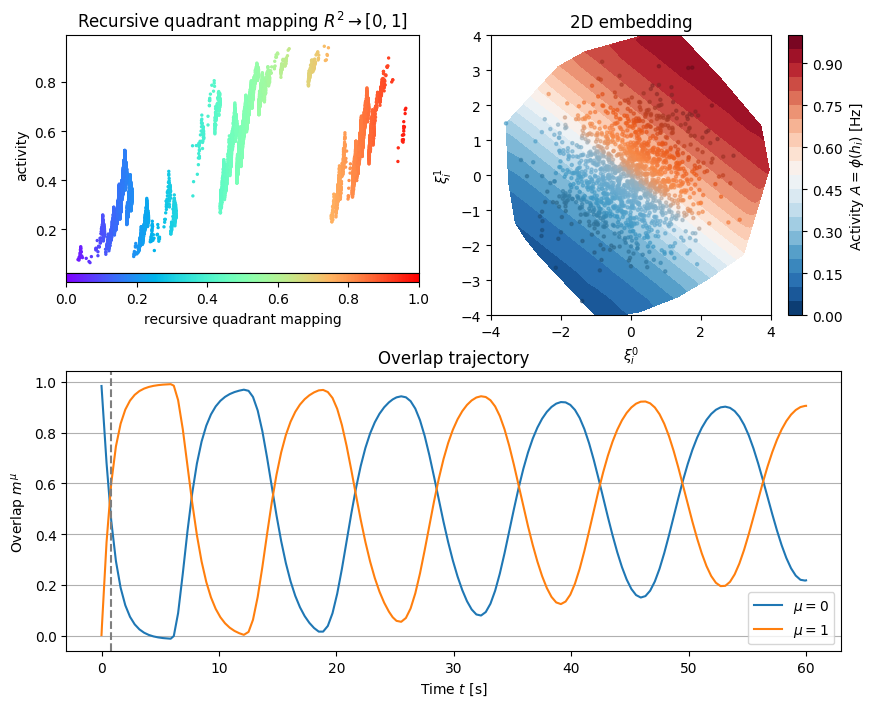

In [50]:
idt = 3
activity_of_t = rnn.phi(res.h)

fig, axes = plt.subplot_mosaic([
	['a','b'],
	['m','m'],
], figsize=(10, 8))

mapping = recursive_quadrant_mapping(rnn.F, n)
scat1d = axes['a'].scatter(mapping, activity_of_t[:, idt], c=mapping, cmap='rainbow', vmin=0, vmax=1, s=2)
axes['a'].xaxis.set_major_locator(plt.NullLocator())
axes['a'].xaxis.set_minor_locator(plt.NullLocator())
axes['a'].set_xlim((0, 1))
axes['a'].set_ylabel('activity')
axes['a'].set_title('Recursive quadrant mapping $R^2 \\rightarrow [0,1]$')
fig.colorbar(scat1d, ax=axes['a'], orientation='horizontal', pad=0, aspect=40, label='recursive quadrant mapping')

_, contour = plot_2D_embedding_contour(rnn, activity_of_t[:, idt], figax=(fig, axes['b']))
_, scat2d = plot_2D_embedding_scatter(rnn, activity_of_t[:, idt], figax=(fig, axes['b']))
axes['b'].set_xlim((-4, 4))
axes['b'].set_ylim((-4, 4))
axes['b'].set_title('2D embedding')

plot_overlap_trajectory(rnn, res, figax=(fig, axes['m']))
line = axes['m'].axvline(res.t[idt], color='tab:gray', linestyle='--')

# things = dict(contour=contour, scat1d=scat1d, scat2d=scat2d)

plt.show()

In [65]:
from pathlib import Path
from tqdm import tqdm
from matplotlib import animation
from math import ceil

def animate2d_vs_1d_recursive_quadrant(rnn: LowRankRNN, res: Result, outpath: Path, time_stride: int = 1, Nmax: int = 1500):
	idt = 0
	activity = rnn.phi(res.h)
	cmap = mpl.colormaps['RdBu_r']

	fig, axes = plt.subplot_mosaic([
		['a','b'],
		['m','m'],
	], figsize=(10, 8))

	mapping = recursive_quadrant_mapping(rnn.F, n)
	scat1d = axes['a'].scatter(mapping, activity[:, idt], c=mapping, cmap='rainbow', vmin=0, vmax=1, s=2)
	axes['a'].xaxis.set_major_locator(plt.NullLocator())
	axes['a'].xaxis.set_minor_locator(plt.NullLocator())
	axes['a'].set_xlim((0, 1))
	axes['a'].set_ylabel('activity')
	axes['a'].set_title('Recursive quadrant mapping $R^2 \\rightarrow [0,1]$')
	fig.colorbar(scat1d, ax=axes['a'], orientation='horizontal', pad=0, aspect=40, label='recursive quadrant mapping')

	_, contour = plot_2D_embedding_contour(rnn, activity[:, idt], figax=(fig, axes['b']))
	_, scat2d = plot_2D_embedding_scatter(rnn, activity[:, idt], figax=(fig, axes['b']))
	axes['b'].set_xlim((-4, 4))
	axes['b'].set_ylim((-4, 4))
	axes['b'].set_title('2D embedding')

	plot_overlap_trajectory(rnn, res, figax=(fig, axes['m']))
	line = axes['m'].axvline(res.t[idt], color='tab:gray', linestyle='--')

	things = dict(contour=contour, scat1d=scat1d, scat2d=scat2d, line=line)

	with tqdm(total=ceil(len(res.t)/time_stride)+1) as pbar:
		def update(idt: int):
			# update the contour
			for artist in things['contour'].collections:
				artist.remove()
			things['contour'] = axes['b'].tricontourf(rnn.F[:, 0], rnn.F[:, 1], activity[:, idt], levels=np.linspace(0, 1, 20+1), cmap='RdBu_r')
			
			# update the line
			things['line'].set_xdata([res.t[idt], res.t[idt]])

			# update the 2d scatter
			things['scat2d'].set_facecolors([ scale_lightness(c[:3], 0.7) for c in cmap(activity[:Nmax, idt]) ])

			# update the 1d scatter
			things['scat1d'].set_offsets(np.column_stack((mapping, activity[:, idt])))

			pbar.update(1)

		ani = animation.FuncAnimation(fig, update, frames=range(0, len(res.t), time_stride))
		ani.save(outpath, writer='ffmpeg', fps=15)

		plt.close()


animate2d_vs_1d_recursive_quadrant(rnn, res, 'animations/mapping_recursive_quadrant.mp4')

100%|██████████| 155/155 [05:16<00:00,  2.04s/it]
